# Predicting Online Shopping Purchase Intentions

This notebook demonstrates how to use machine learning to predict whether a user will make a purchase in an online shopping session. Models and visualizations are chosen to be clear and understandable for beginners.

---

## Introduction

We aim to predict purchase conversion on an e-commerce site. This helps a business target nudges to potential buyers, maximizing conversions and minimizing wasted efforts.

---

## Dataset Description

Data: "Online Shoppers Intention"  
- Features: page views, durations, visitor type, weekend, etc.
- Target: `Revenue` (1 = purchase, 0 = no purchase)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("online_shoppers_intention.csv")
print(df.head())
print(df.info())
print(df['Revenue'].value_counts())


   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb   

In [2]:
# ==============================
# Data Preprocessing
# ==============================

# 1. Boolean columns to integer
df[["Weekend", "Revenue"]] = df[["Weekend", "Revenue"]].astype(int)

# 2. One-hot encode VisitorType
df = pd.get_dummies(df, columns=['VisitorType'], drop_first=True)

# 3. Map month names to numbers
month_map = {'Feb': 2, 'Mar': 3, 'May': 5, 'Oct': 10, 'June': 6, 'Jul': 7,
              'Aug': 8, 'Nov': 11, 'Sep': 9, 'Dec': 12}
df["Month"] = df["Month"].map(month_map)

# 4. Feature engineering: total page views and duration
df["Total_PageViews"] = df["Administrative"] + df["Informational"] + df["ProductRelated"]
df["Total_PageDuration"] = df["Administrative_Duration"] + df["Informational_Duration"] + df["ProductRelated_Duration"]

# 5. Drop original columns
df.drop(columns=["Administrative", "Informational", "ProductRelated",
                 "Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"], inplace=True)

# Remove underscores in column names
df.columns = df.columns.str.replace("_", "", regex=False)
# Preview processed data
df.head()



,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,VisitorTypeOther,VisitorTypeReturningVisitor,TotalPageViews,TotalPageDuration
0,0.20,0.20,0.0,0.0,2,1,1,1,1,0,0,False,True,1,0.000000
1,0.00,0.10,0.0,0.0,2,2,2,1,2,0,0,False,True,2,64.000000
2,0.20,0.20,0.0,0.0,2,4,1,9,3,0,0,False,True,1,0.000000
3,0.05,0.14,0.0,0.0,2,3,2,2,4,0,0,False,True,2,2.666667
4,0.02,0.05,0.0,0.0,2,3,3,1,4,1,0,False,True,10,627.500000


## EDA (Exploratory Data Analysis)


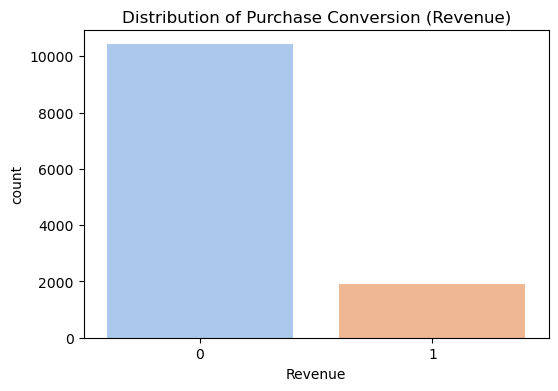

In [3]:
# Distribution of target label
plt.figure(figsize=(6,4))
# sns.countplot(x='Revenue', data=df, palette='pastel')
sns.countplot(x="Revenue", data=df, hue="Revenue", palette="pastel", legend=False)
plt.title('Distribution of Purchase Conversion (Revenue)')
plt.show()


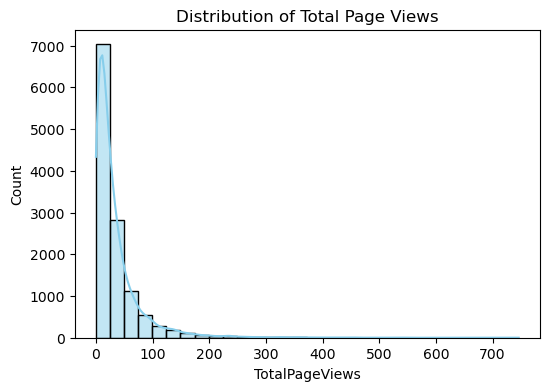

In [9]:
# Distribution of Total Page Views
plt.figure(figsize=(6,4))
sns.histplot(df['TotalPageViews'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Total Page Views')
plt.show()


## Model Comparison: Metrics & Visuals

We compare five models with precision-recall curves:
- Logistic Regression
- Support Vector Machine (SVM)
- Decision Tree
- Random Forest
- K-Nearest Neighbors (KNN)

We train models, scale features, and plot metric curves for comparison.


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer


In [13]:
# Train-test split (stratified)
X = df.drop('Revenue', axis=1)
y = df['Revenue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

#Scale numeric columns 
scale_cols = ["PageValues", "TotalPageViews", "TotalPageDuration"]
passthrough_cols = [col for col in X_train.columns if col not in scale_cols]

# ColumnTransformer: scale only selected cols, passthrough others
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), scale_cols)   # scale these
    ],
    remainder="passthrough"   # keep all other columns as-is
)

# Fit on training and transform both
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


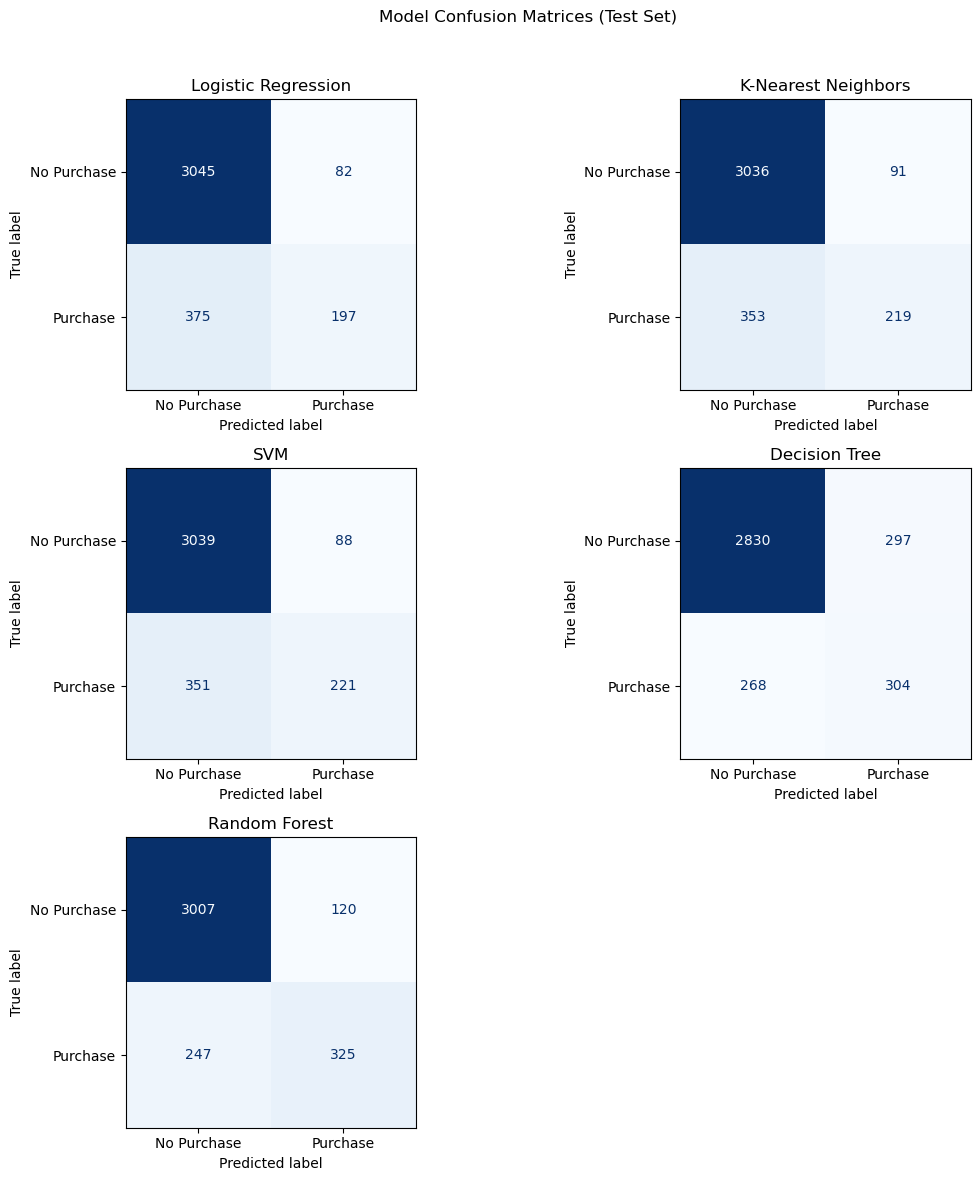

In [15]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),
    "SVM": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1)
}

plt.figure(figsize=(12, 12))

for idx, (name, model) in enumerate(models.items()):
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    
    ax = plt.subplot(3, 2, idx + 1)
    ConfusionMatrixDisplay.from_predictions(
        y_test, 
        y_pred,
        display_labels=["No Purchase", "Purchase"],
        cmap=plt.cm.Blues,
        colorbar=False,
        ax=ax
    )
    plt.title(name)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

plt.suptitle("Model Confusion Matrices (Test Set)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


--- Starting Full Model Comparison ---
Model: Logistic Regression completed in 2.94 seconds.
Model: K-Nearest Neighbors completed in 2.27 seconds.
Model: SVM completed in 31.06 seconds.
Model: Decision Tree completed in 0.21 seconds.
Model: Random Forest completed in 1.26 seconds.

--- Final Model Performance Table Order By F1-Score ---
              Model  Precision  Recall  F1 Score  ROC AUC  Accuracy
      Random Forest       0.73    0.57      0.64     0.91      0.90
      Decision Tree       0.51    0.53      0.52     0.72      0.85
                SVM       0.72    0.39      0.50     0.88      0.88
K-Nearest Neighbors       0.71    0.38      0.50     0.79      0.88
Logistic Regression       0.71    0.34      0.46     0.89      0.88

--- Generating Precision-Recall Curves ---


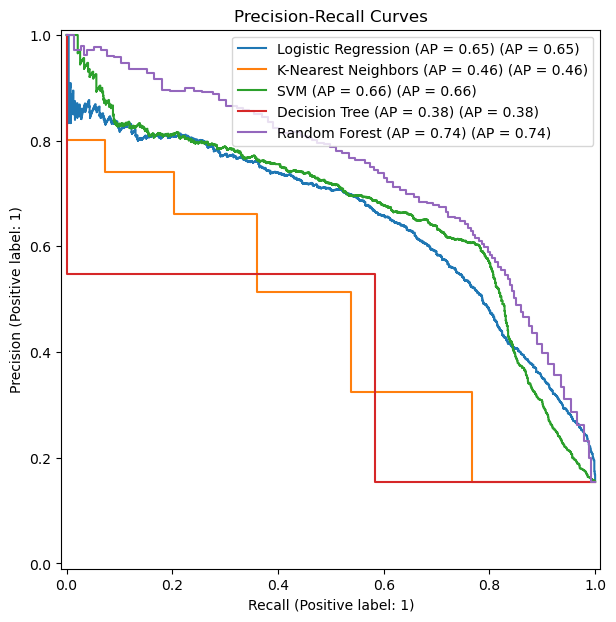

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),
    "SVM": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1)
}

all_results = []
print("--- Starting Full Model Comparison ---")

for name, model in models.items():
    start_time = time.time()
    
  
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    
    all_results.append({
        'Model': name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Accuracy': accuracy
    })
    
    
    end_time = time.time()
    print(f"Model: {name} completed in {end_time - start_time:.2f} seconds.")


results = pd.DataFrame(all_results)
results_sorted = results.sort_values(by='F1 Score', ascending=False).round(2)

print("\n--- Final Model Performance Table Order By F1-Score ---")
print(results_sorted.to_string(index=False))

# Compare models with precision-recall curves
print("\n--- Generating Precision-Recall Curves ---")

plt.figure(figsize=(10, 7))
ax = plt.gca()

for name, model in models.items():
    # Use cross-validation to get probabilities for the training set
    y_proba = cross_val_predict(model, X_train_scaled, y_train, cv=5, method="predict_proba", n_jobs=-1)[:, 1]
    
    ap = average_precision_score(y_train, y_proba)
    PrecisionRecallDisplay.from_predictions(
        y_train,
        y_proba,
        name=f"{name} (AP = {ap:.2f})",
        ax=ax
    )

plt.title("Precision-Recall Curves")
plt.xlabel("Recall (Positive label: 1)")
plt.ylabel("Precision (Positive label: 1)")
plt.legend(loc="upper right")
plt.show()




In [17]:
rf_base_scaled = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_base_scaled.fit(X_train_scaled, y_train)
y_pred_base_scaled = rf_base_scaled.predict(X_test_scaled)
print("Random Forest with scaling Test Data") 
print(f"F1 Score: {f1_score(y_test, y_pred_base_scaled):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_base_scaled)}")
print(classification_report(y_test, y_pred_base_scaled, zero_division=0))


Random Forest with scaling Test Data
F1 Score: 0.6391
Confusion Matrix:
[[3007  120]
 [ 247  325]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3127
           1       0.73      0.57      0.64       572

    accuracy                           0.90      3699
   macro avg       0.83      0.76      0.79      3699
weighted avg       0.89      0.90      0.90      3699



In [19]:
#2.a Rndom Forest without scaling Test Data
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)
print("🔹2.a Rndom Forest without scaling Test Data🔹") 
print(f"F1 Score: {f1_score(y_test, y_pred_base):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_base)}")
print(classification_report(y_test, y_pred_base, zero_division=0))



🔹2.a Rndom Forest without scaling Test Data🔹
F1 Score: 0.6135
Confusion Matrix:
[[3003  124]
 [ 264  308]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3127
           1       0.71      0.54      0.61       572

    accuracy                           0.90      3699
   macro avg       0.82      0.75      0.78      3699
weighted avg       0.89      0.90      0.89      3699



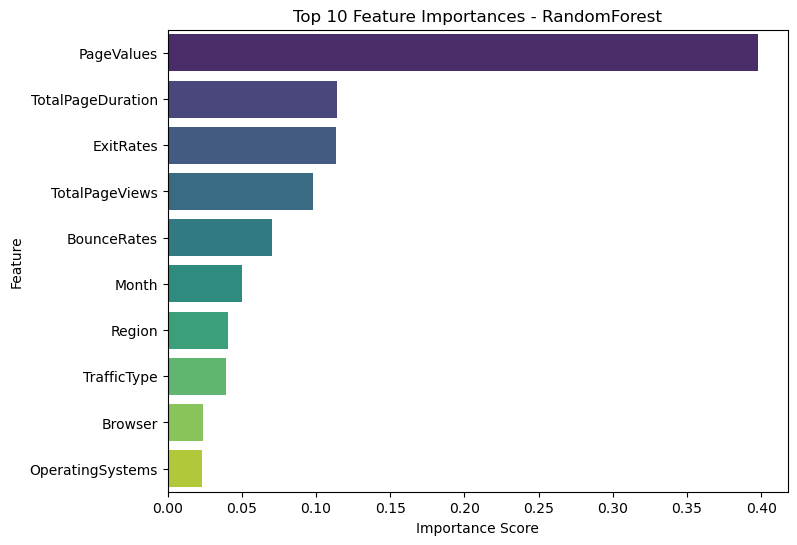

In [21]:
# Feature Importance
feat_imp = pd.Series(rf_base.feature_importances_, index=X_train.columns).sort_values(ascending=False)


plt.figure(figsize=(8,6))

sns.barplot(
    x=feat_imp[:10],
    y=feat_imp.index[:10],
    palette="viridis",
    hue=feat_imp.index[:10],   # necessary for palette
    dodge=False,
    legend=False
)

plt.title("Top 10 Feature Importances - RandomForest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [23]:
#2b. Random Forest with SMOTE Test Data 
print("🔹 2b. Random Forest with SMOTE Test Data 🔹")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
rf_smote = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = rf_smote.predict(X_test)
print(f"F1 Score: {f1_score(y_test, y_pred_smote):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_smote)}")
print(classification_report(y_test, y_pred_smote, zero_division=0))


🔹 2b. Random Forest with SMOTE Test Data 🔹
F1 Score: 0.6352
Confusion Matrix:
[[2846  281]
 [ 175  397]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      3127
           1       0.59      0.69      0.64       572

    accuracy                           0.88      3699
   macro avg       0.76      0.80      0.78      3699
weighted avg       0.89      0.88      0.88      3699



In [25]:
# 2c: Random Forest with K-Fold Cross-Validation Training Data
print("🔹 2c. Random Forest with K-Fold CV Train Data 🔹")
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_kfold = RandomForestClassifier(random_state=42, n_jobs=-1)
y_pred_kfold = cross_val_predict(rf_kfold, X_train, y_train, cv=cv_strategy, n_jobs=-1)
print(f"F1 Score (on training set with CV): {f1_score(y_train, y_pred_kfold):.4f}")
print(f"Confusion Matrix (on training set with CV):\n{confusion_matrix(y_train, y_pred_kfold)}")
print(classification_report(y_train, y_pred_kfold, zero_division=0))


🔹 2c. Random Forest with K-Fold CV Train Data 🔹
F1 Score (on training set with CV): 0.6419
Confusion Matrix (on training set with CV):
[[7021  274]
 [ 575  761]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7295
           1       0.74      0.57      0.64      1336

    accuracy                           0.90      8631
   macro avg       0.83      0.77      0.79      8631
weighted avg       0.90      0.90      0.90      8631



In [27]:
# 2d: Random Forest with K-Fold Cross-Validation Test Data
print("🔹 2d. Random Forest with K-Fold CV Test Data 🔹")
cv_strategy_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_kfold_test = RandomForestClassifier(random_state=42, n_jobs=-1)
y_pred_kfold_test = cross_val_predict(rf_kfold_test, X_test, y_test, cv=cv_strategy_test, n_jobs=-1)
print(f"F1 Score (on testing set with CV): {f1_score(y_test, y_pred_kfold_test):.4f}")
print(f"Confusion Matrix (on testing set with CV):\n{confusion_matrix(y_test, y_pred_kfold_test)}")
print(classification_report(y_test, y_pred_kfold_test, zero_division=0))

🔹 2d. Random Forest with K-Fold CV Test Data 🔹
F1 Score (on testing set with CV): 0.5876
Confusion Matrix (on testing set with CV):
[[3014  113]
 [ 287  285]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      3127
           1       0.72      0.50      0.59       572

    accuracy                           0.89      3699
   macro avg       0.81      0.73      0.76      3699
weighted avg       0.88      0.89      0.88      3699



In [31]:
# 2f: Random Forest with SMOTE & K-Fold (Pipeline) Test Data
print("🔹 2f. Random Forest with SMOTE & K-Fold (Pipeline) Test Data 🔹")
pipeline_test = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])
cv_strategy_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_smote_kfold_test = cross_val_predict(pipeline_test, X_test, y_test, cv=cv_strategy_test, n_jobs=-1)
print(f"F1 Score (on testing set with Pipeline CV): {f1_score(y_test, y_pred_smote_kfold_test):.4f}")
print(f"Confusion Matrix (on testing set with Pipeline CV):\n{confusion_matrix(y_test, y_pred_smote_kfold_test)}")
print(classification_report(y_test, y_pred_smote_kfold_test, zero_division=0))

🔹 2f. Random Forest with SMOTE & K-Fold (Pipeline) Test Data 🔹
F1 Score (on testing set with Pipeline CV): 0.6483
Confusion Matrix (on testing set with Pipeline CV):
[[2867  260]
 [ 173  399]]
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3127
           1       0.61      0.70      0.65       572

    accuracy                           0.88      3699
   macro avg       0.77      0.81      0.79      3699
weighted avg       0.89      0.88      0.89      3699



In [29]:
# 2e: Random Forest with SMOTE & K-Fold (Pipeline) Train Data
print("🔹 2e. Random Forest with SMOTE & K-Fold (Pipeline) Train Data 🔹")
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#smote, kfold
y_pred_smote_kfold_train = cross_val_predict(pipeline, X_train, y_train, cv=cv_strategy, n_jobs=-1)
print(f"F1 Score (on training set with SMOTE & K-Fold (Pipeline) CV): {f1_score(y_train, y_pred_smote_kfold_train):.4f}")
print(f"Confusion Matrix (on training set with SMOTE & K-Fold (Pipeline) CV):\n{confusion_matrix(y_train, y_pred_smote_kfold_train)}")
print(classification_report(y_train, y_pred_smote_kfold_train, zero_division=0))


🔹 2e. Random Forest with SMOTE & K-Fold (Pipeline) Train Data 🔹
F1 Score (on training set with SMOTE & K-Fold (Pipeline) CV): 0.6721
Confusion Matrix (on training set with SMOTE & K-Fold (Pipeline) CV):
[[6683  612]
 [ 350  986]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      7295
           1       0.62      0.74      0.67      1336

    accuracy                           0.89      8631
   macro avg       0.78      0.83      0.80      8631
weighted avg       0.90      0.89      0.89      8631



In [33]:
# Define the model to be tuned
rf = RandomForestClassifier(random_state=42, n_jobs=-1)


param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 10],
    "max_features": ["sqrt", "log2", None]
}

# Use StratifiedKFold for cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Starting hyperparameter tuning for F1 score...")
start_time = time.time()


random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  
    cv=cv_strategy,
    scoring="f1",  
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search.fit(X_train, y_train)

end_time = time.time()
print(f"Randomized search took {end_time - start_time:.2f} seconds.")

print("\nBest hyperparameters found:")
print(random_search.best_params_)
print(f"Best cross-validation F1 score: {random_search.best_score_:.4f}")

best_rf = random_search.best_estimator_


print("\nTraining the best model on the full training set...")
start_time = time.time()
best_rf.fit(X_train, y_train)
end_time = time.time()
print(f"Training took {end_time - start_time:.4f} seconds.")


y_test_pred = best_rf.predict(X_test)


print("\n🔹 Final Evaluation on Test Set 🔹")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred, zero_division=0))


y_test_pred_proba = best_rf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

Starting hyperparameter tuning for F1 score...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Randomized search took 330.51 seconds.

Best hyperparameters found:
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10}
Best cross-validation F1 score: 0.6713

Training the best model on the full training set...
Training took 3.3959 seconds.

🔹 Final Evaluation on Test Set 🔹
F1 Score: 0.6409
Confusion Matrix:
 [[2995  132]
 [ 240  332]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94      3127
           1       0.72      0.58      0.64       572

    accuracy                           0.90      3699
   macro avg       0.82      0.77      0.79      3699
weighted avg       0.89      0.90      0.90      3699

ROC AUC Score: 0.9199


In [35]:
# --- Step 3: Final Model with Best Parameters ---
print("--- Step 3: Final Model with Best Parameters Test Data ---")

best_params = {
    'n_estimators': 300,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': None,
    'max_depth': 10,
    'bootstrap': True
}

final_rf_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
final_rf_model.fit(X_train, y_train)

y_pred_final = final_rf_model.predict(X_test)
y_proba_final = final_rf_model.predict_proba(X_test)[:, 1]

print("🔹 Final Evaluation on Test Set🔹")
print(f"F1 Score: {f1_score(y_test, y_pred_final):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final))
print("Classification Report:\n", classification_report(y_test, y_pred_final, zero_division=0))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_final):.4f}")


--- Step 3: Final Model with Best Parameters Test Data ---
🔹 Final Evaluation on Test Set🔹
F1 Score: 0.6409
Confusion Matrix:
 [[2995  132]
 [ 240  332]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94      3127
           1       0.72      0.58      0.64       572

    accuracy                           0.90      3699
   macro avg       0.82      0.77      0.79      3699
weighted avg       0.89      0.90      0.90      3699

ROC AUC Score: 0.9199


In [37]:
import joblib
final_model_to_save = RandomForestClassifier(random_state=42, n_jobs=-1)

# Train the model on the full training set
print("Training the Random Forest model for final save...")
start_time = time.time()
final_model_to_save.fit(X_train_scaled, y_train)
end_time = time.time()
print(f"Training took {end_time - start_time:.2f} seconds.")

model_filename = "final_rf_model.joblib"
joblib.dump(final_model_to_save, model_filename)

print(f"\nFinal model saved to '{model_filename}'")

Training the Random Forest model for final save...
Training took 0.66 seconds.

Final model saved to 'final_rf_model.joblib'
